## [Improve Accuracy of OCR using Image Preprocessing](https://medium.com/cashify-engineering/improve-accuracy-of-ocr-using-image-preprocessing-8df29ec3a033)
- OCR output highly depends on the quality of input image.    
- This is why every OCR engine provides guidelines regarding the quality of input image and its size. 
- These guidelines help OCR engine to produce accurate results.    
- Here Image Preprocessing comes into play to improve the quality of input image so that the OCR engine gives you an accurate output.
---
- **OCR의 결과는 입력 이미지의 Quality에 많은 의존성을 가진다**
- 이것은 모든 OCR Engine이 입력 이미지의 Quality와 이미지의 사이즈에 대한 가이드라인을 제공하는 이유이다
- 이러한 가이드라인은 OCR Engine이 정확한 결과를 생산하는 것을 도울것이다
- **이미지 전처리는 입력이미지의 Quality를 향상 시켜서 OCR Engine이 너에게 정확한 결과를 주도록 할 것 이다**

### Scaling of image 
- Image Rescaling is important for image analysis. 
- Mostly OCR engine give an accurate output of the image which has 300 DPI. 
- DPI describes the resolution of the image or in other words, it denotes printed dots per inch.
---
- 이미지 Rescaling은 이미지 분석에 매우 중요하다
- **대부분의 OCR Engine은 이미지가 300 DPI일때 정확한 결과를 준다**
- DPI는 이미지의 Resolution(해상도)를 나타내고, 다른 말로 인치당 표시되는 도트의 수를 나타낸다


### Noise Removal or Denoise
- Noise is a random variation of color or brightness between pixels of an image. 
- Noise decrease the readability of text from an image. 
- There are two major types of noise - salt and pepper noise and Gaussian noise.
---
- Noise는 이미지의 픽셀들 사이에 있는 밝기나 색깔의 랜덤한 변화이다
- **Noise는 이미지에 있는 Text의 가독성을 감소한다**
- 주요한 두가지 종류의 Noise : Salt and Pepper Noise와 Gaussian Noise가 있다, 

### Skew Correction
- A Skewed image is defined as a document image which is not straight. 
- Skewed images directly impact the line segmentation of OCR engine which reduces its accuracy. 
- We need to process the following steps to correct text skew.
---
- Skewed(왜곡된, 비스듬한, 기울어진) Image는 똑바르지 않은 문서 이미지로 정의된다 
- **Skewed Image(기울어진 이미지)는 OCR Engine의 Line Segmentation에 영향을 준다, 이것은 정확도를 줄인다**
- 우리는 기울어진 텍스트를 올바르게 만들기 위해 아래와 같은 처리가 필요하다

### Binarization
- Mostly, an OCR engine does binarization internally because they work on Black & White images. 
- The simplest way is to calculate a threshold value and convert all pixels to white with a value above threshold value and rest of pixels convert into the black. 
- I am using OpenCV with Simple Thresholding, Adaptive Thresholding, and Otsu’s Binarization.
---
- **대부분의 OCR Engine은 내부적으로 이진화를 수행한다 그것들이 흑백 이미지에서 잘 작동하기 때문이다**
- 가장 간단한 방법은 Threshold(임계값) 값을 계산하는 것이다, Threshold 값보다 큰 픽셀값은 모두 하얀색으로 바꾸고 나머지 픽셀은 검은색으로 바꾼다
- OpenCV의 [Simple Thresholding, Adaptive Thresholding, and Otsu’s Binarization] 를 사용한다

### Useful Links 
- There are plenty of tools and articles for image processing on the internet. 
- I am putting up some useful links which can help you to implement these process to improve your accuracy.
---
- 인터넷에는 이미지 처리를 위한 많은 도구와 기사가 있다
- 정확도를 향상시키기 위한 처리를 시도하는데 도움이 될 유용한 링크를 마련했다    
- 2, 3번 링크도 번역 해봐야겠다    

[Image processing OpenCV](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_table_of_contents_imgproc/py_table_of_contents_imgproc.html)    
[Skew correction using python](https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/)    
[Mobile document scanner](https://www.pyimagesearch.com/2014/09/01/build-kick-ass-mobile-document-scanner-just-5-minutes/)    

#### 1. Detect the text block with skew in the image.
#### 2. Now calculate the angle of rotation.
#### 3. Rotating the image to correct the skew.
----
#### 1. 이미지에서 기울어진 Text Block 탐지하기
#### 2. 회전 각도 계산
#### 3. 비스듬한 이미지를 바르게 만들도록 이미지 회전

In [352]:
from PIL import Image
import cv2
import numpy as np
import os
import tempfile
import matplotlib.pyplot as plt

# imutils : OpenCV가 제공하는 기능 중에 좀 복잡하고 사용성이 떨어지는 부분을 잘 보완해 주는 패키지
# https://enjoyimageprocessing.tistory.com/entry/imutils-package-%EA%B8%B0%EB%8A%A5
import imutils


In [396]:
# 이미지 경로를 입력받아 300dpi로 변환 후 확장자는 png로 저장한다, return 저장된 파일 이름
def set_image_dpi(file_path):
    im = Image.open(file_path)
    w, h = im.size
    
    # x가 1024보다 크면 1024 사이즈로 축소
    # x가 1024보다 작으면 원본 사이즈 그대로
    factor = min(1, float(1024.0 / w))
    size = int(factor * w), int(factor * h)
    
    # resize랑 save부분 검토 필요!
    im_resized = im.resize(size, Image.ANTIALIAS)
    
    filename = os.getcwd() + '/images/Preprocessing_tmp.png'
    im_resized.save(filename, dpi=(300, 300))
    
    show_img(im_resized, 'set_image_dpi')
    return im_resized

In [387]:
# https://medium.com/@brijesh.vicky/hi-reza-cc2089800f41
# 원본 문서에 BINARY_THREHOLD가 정의되어 있지 않다
# https://opencv-python.readthedocs.io/en/latest/doc/09.imageThresholding/imageThresholding.html
# 위에 있는 링크에서 "Otsu의 이진화"에 있는 Sample Code와 아래의 코드가 유사한것을 발견, BINARY_THREHOLD를 127로 정의한다
def image_smoothening(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    BINARY_THREHOLD = 127
    ret1, th1 = cv2.threshold(img, BINARY_THREHOLD, 255, cv2.THRESH_BINARY)
    ret2, th2 = cv2.threshold(th1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    blur = cv2.GaussianBlur(th2, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    show_img(th3, 'image_smoothening')
    return th3

In [388]:
def find_contours(image):
    smooth_image = image_smoothening(image)

    edged = cv2.Canny(smooth_image, 10, 50)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break

    cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
    show_img(image, 'find_contours')
    return image, screenCnt

In [389]:
# https://medium.com/@brijesh.vicky/thanks-for-writing-i-am-sending-you-detail-of-above-two-variable-8134ed7f3020

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect

In [390]:
def four_point_transform(image, screenCnt):
    # And orig is copy of original image
    orig = image.copy()
    
    # what_size는 이미지에 따라 다른 값을 가져야 된다
    what_size = 800.0 
    ratio = what_size / image.shape[0]
    dim = (int(image.shape[1] * ratio), 800)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    pts = np.array(screenCnt.reshape(4, 2) / ratio)
    
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left
    # order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))
    
    show_img(warped, 'transform')
    return warped

In [391]:
def show_img(image, alt='img'):
    plt.figure()
    plt.title(alt)
    plt.imshow(image)

In [394]:
def main():
    #파일 경로 설정
    cur_path = os.getcwd()
    file_name = 'document.jpg' 
    img_path = cur_path + '/images/' + file_name
    
    # set_image_dpi 함수 호출
    image = set_image_dpi(img_path)
    
    # Convert PIL Image to cv2 Image
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    orig = image.copy()
    
    # find_contours 함수 호출
    image, screenCnt = find_contours(image)
    
    # four_point_transform 함수 호출
    warped = four_point_transform(orig, screenCnt)


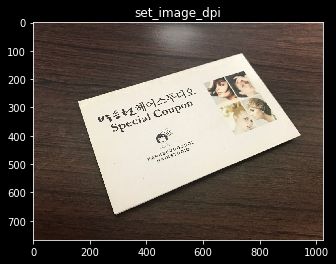

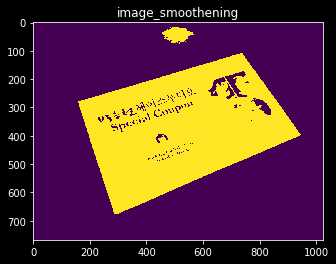

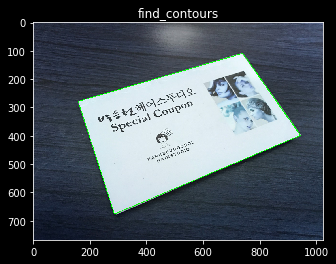

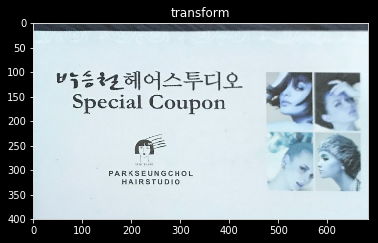

In [395]:
main()

### Memo
- set_image_dpi
 - Image resize랑 save부분 검토 필요!
- four_point_transform
 - 방향이 이상하게 변환된다
 - 수정 필요

#### Result
외곽검출 잘됨
- test2.png : 배경 검은색
- document.jpg : 배경 어두움

외곽검출 안됨
- receipt1.jpg, receipt5.png
- test1.png